In [17]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score
from torchinfo import summary
import torch.nn as nn
import argparse, os, json, sys
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import h5py
from EvalTools import *
sys.path.append("../model")
from PFINDataset import PFINDataset
from UQPFIN import UQPFIN as Model
import gc
import glob
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
dataset = 'jetclass'
results_dir = 'results/'
result_files = [f for f in os.listdir(results_dir) if dataset in f]
print('\n'.join(result_files))

RESULTS_UQPFIN_Ensemble_jetclass_skiptop.h5
RESULTS_UQPFIN_best_jetclass_nominal_v2_baseline.h5
RESULTS_UQPFIN_best_jetclass_nominal_v2_skipwz.h5
RESULTS_UQPFIN_best_jetclass_0_skiptop.h5
RESULTS_UQPFIN_best_jetclass_0_baseline.h5
RESULTS_UQPFIN_best_jetclass_0_skiptwz.h5
RESULTS_UQPFIN_best_jetclass_nominal_v1_skiph.h5
RESULTS_UQPFIN_MCDO_jetclass_skiph.h5
RESULTS_UQPFIN_best_jetclass_nominal_0.1_v1_skiph.h5
RESULTS_UQPFIN_Ensemble_jetclass_skiph.h5
RESULTS_UQPFIN_best_jetclass_nominal_0.1_v1_baseline.h5
RESULTS_UQPFIN_best_jetclass_0_skipwz.h5
RESULTS_UQPFIN_best_jetclass_nominal_0.1_v1_skipwz.h5
RESULTS_UQPFIN_Ensemble_jetclass_skipwz.h5
RESULTS_UQPFIN_best_jetclass_nominal_v1_skiptwz.h5
RESULTS_UQPFIN_best_jetclass_0_skiph.h5
RESULTS_UQPFIN_best_jetclass_nominal_0.1_v2_skiptwz.h5
RESULTS_UQPFIN_best_jetclass_nominal_v2_skiptop.h5
RESULTS_UQPFIN_Ensemble_jetclass_skiptwz.h5
RESULTS_UQPFIN_best_jetclass_nominal_0.1_v2_skiptop.h5
RESULTS_UQPFIN_Ensemble_jetclass_baseline.h5


In [5]:
tags = []
for modelname in result_files:
    if "Ensemble" in modelname or "MCDO" in modelname:
        tag = modelname.strip().split('_')[-1][:-3]
        if tag not in tags:
            tags.append(tag)
print("\n".join(tags))

skiptop
skiph
skipwz
skiptwz
baseline


skiph


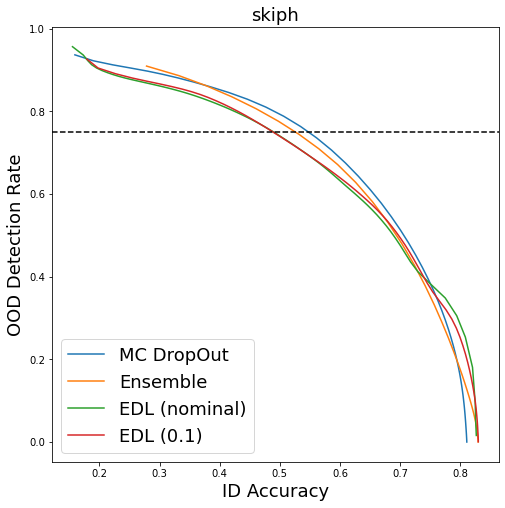

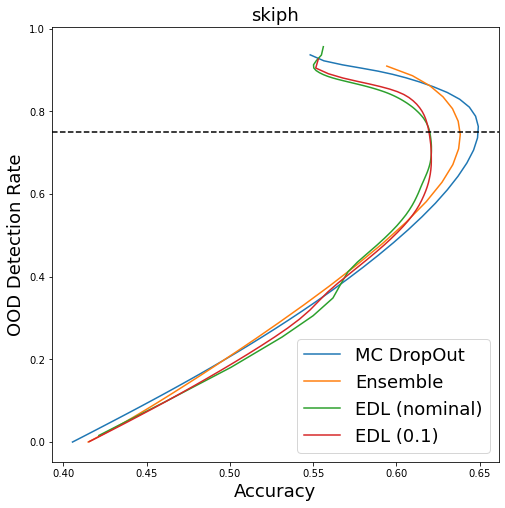

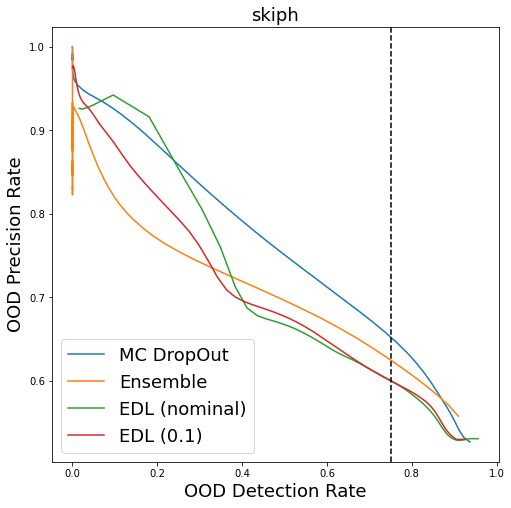

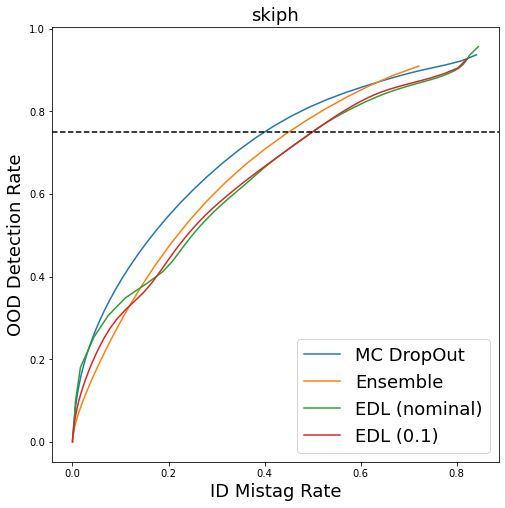

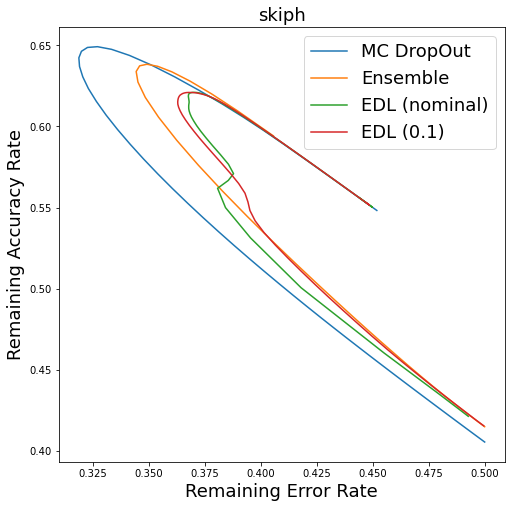

In [18]:
for tag in tags:
    if tag == 'baseline':
        continue
    print(tag)
    model_results = {}
    plotter_map = {}
    
    fnames = ["RESULTS_UQPFIN_MCDO_" + dataset + "_{}.h5",
              "RESULTS_UQPFIN_Ensemble_" + dataset + "_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "_nominal_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "_0.1_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "_0.5_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "_0.7_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "_0.1_{}_ocmodel.h5",
              "RESULTS_UQPFIN_best_" + dataset + "_0.5_{}_ocmodel.h5",
              "RESULTS_UQPFIN_best_" + dataset + "_0.7_{}_ocmodel.h5",
              ]
    fnames = [os.path.join(results_dir, f) for f in fnames]
    types = ["MC DropOut", "Ensemble", "EDL (nominal)", "EDL (0.1)", 
             "EDL (0.5)", "EDL (0.7)", "EDL-CT (0.1)", "EDL-CT (0.5)", "EDL-CT (0.7)" ]
            
    if dataset != "jetnet":
        fnames = fnames[0: len(fnames) - 5]
        types = types[0: len(types) - 5]
    
    if dataset == "jetclass":
        fnames[2] = fnames[2][:-6] + "_v*" + fnames[2][-6:]
        fnames[3] = fnames[3][:-10] + "_nominal" + fnames[3][-10:-6] + "_v*" + fnames[3][-6:]
        
    for ii, fname in enumerate(fnames):
        fname = glob.glob(fname.format(tag))[-1]
        f = h5py.File(fname, "r")
        model_results[types[ii]] = {'labels' : f['labels'][:], 
                                   'preds': f['preds'][:], 
                                   'maxprobs': f['maxprobs'][:],
                                   'sums':f['sums'][:], 
                                   'oods':f['oods'][:],
                                   'uncs': f['uncs'][:],
                                   'probs': f['probs'][:]}
        f.close()
        plotter_map[types[ii]] = PlotterTools(model_results[types[ii]], types[ii])

    
    
    
    fig, ax = plt.subplots(figsize=(8,8))
    for _t in types:
        plotter_map[_t].ODR_IDAcc(ax)
    ax.axhline(0.75, color = "k", linestyle= "--")
    ax.legend(fontsize = 18)
    ax.set_ylabel("OOD Detection Rate", fontsize = 18)
    ax.set_xlabel("ID Accuracy", fontsize = 18)
    ax.set_title(tag, fontsize=18)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(8,8))
    for _t in types:
        plotter_map[_t].ODR_Acc(ax)
    ax.axhline(0.75, color = "k", linestyle= "--")
    ax.legend(fontsize = 18)
    ax.set_ylabel("OOD Detection Rate", fontsize = 18)
    ax.set_xlabel("Accuracy", fontsize = 18)
    ax.set_title(tag, fontsize=18)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(8,8))
    for _t in types:
        plotter_map[_t].OCR_ODR(ax)
    ax.axvline(0.75, color = "k", linestyle= "--")
    ax.legend(fontsize = 18)
    ax.set_xlabel("OOD Detection Rate", fontsize = 18)
    ax.set_ylabel("OOD Precision Rate", fontsize = 18)
    ax.set_title(tag, fontsize=18)
    plt.show()
    
    
    
    fig, ax = plt.subplots(figsize=(8,8))
    for _t in types:
        plotter_map[_t].ODR_IMR(ax)
    ax.axhline(0.75, color = "k", linestyle= "--")
    ax.legend(fontsize = 18)
    ax.set_ylabel("OOD Detection Rate", fontsize = 18)
    ax.set_xlabel("ID Mistag Rate", fontsize = 18)
    ax.set_title(tag, fontsize=18)
    plt.show()
    
    
    fig, ax = plt.subplots(figsize=(8,8))
    for _t in types:
        plotter_map[_t].RAR_RER(ax)
    ax.legend(fontsize = 18)
    ax.set_ylabel("Remaining Accuracy Rate", fontsize = 18)
    ax.set_xlabel("Remaining Error Rate", fontsize = 18)
    ax.set_title(tag, fontsize=18)
    plt.show()
    
    print('\n\n')
    del model_results
    gc.collect()

baseline


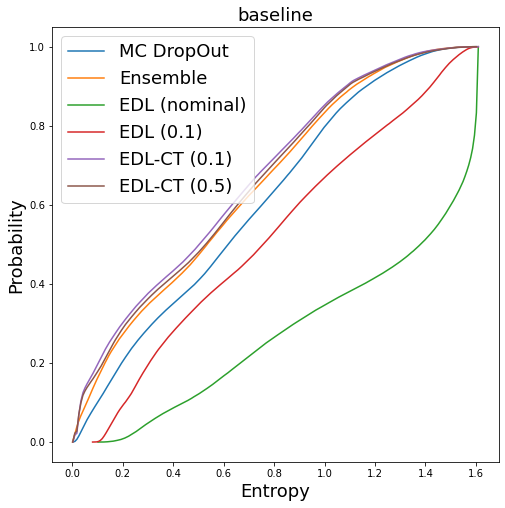




skiptop


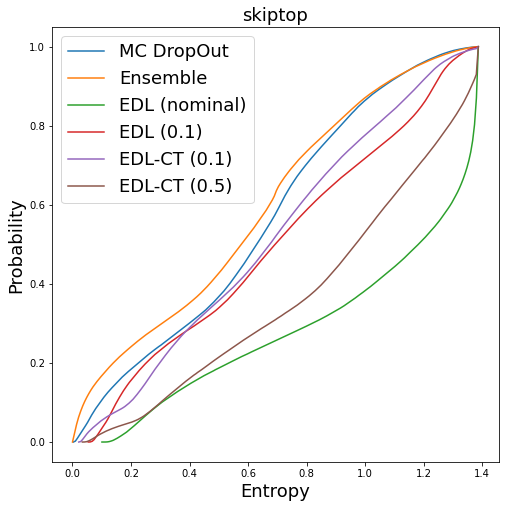

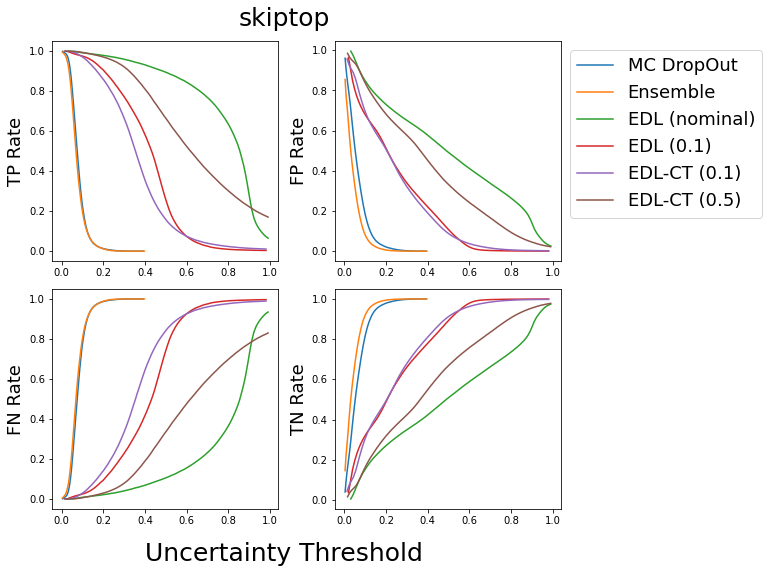




skipwz


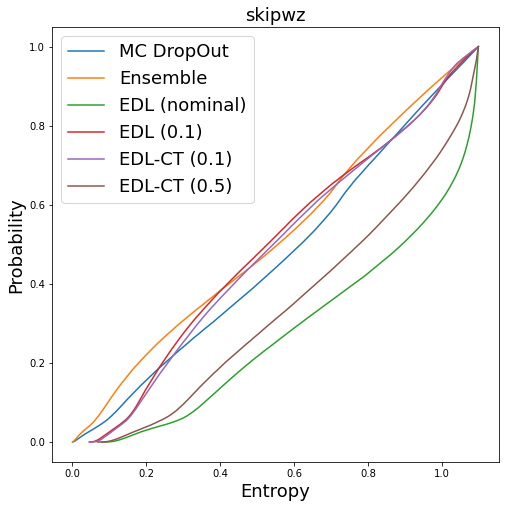

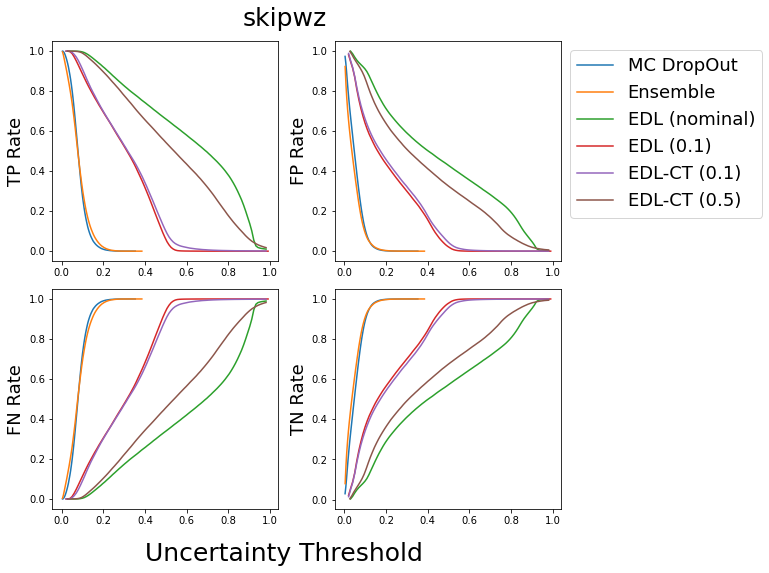




skiptwz


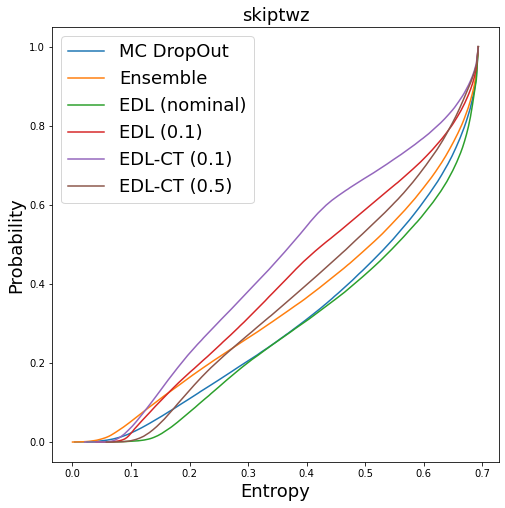

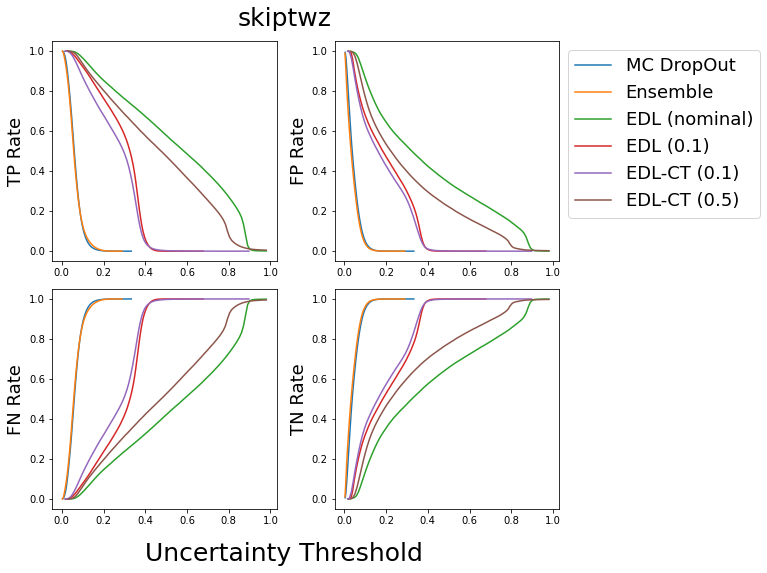

In [22]:
for tag in tags:
    print(tag)
    model_results = {}
    plotter_map = {}
    
    fnames = ["RESULTS_UQPFIN_MCDO_" + dataset + "_{}.h5",
              "RESULTS_UQPFIN_Ensemble_" + dataset + "_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "_nominal_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "_0.1_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "_0.1_{}_ocmodel.h5",
              "RESULTS_UQPFIN_best_" + dataset + "_0.5_{}_ocmodel.h5",
              ]
    fnames = [os.path.join(results_dir, f) for f in fnames]
    types = ["MC DropOut", "Ensemble", "EDL (nominal)", "EDL (0.1)", "EDL-CT (0.1)", "EDL-CT (0.5)" ]
    if dataset != "jetnet":
        fnames = fnames[0: len(fnames) - 2]
        types = types[0: len(types) - 2]
    
    for ii, fname in enumerate(fnames):
        fname = fname.format(tag)
        f = h5py.File(fname, "r")
        model_results[types[ii]] = {'labels' : f['labels'][:], 
                                   'preds': f['preds'][:], 
                                   'maxprobs': f['maxprobs'][:],
                                   'sums':f['sums'][:], 
                                   'oods':f['oods'][:],
                                   'uncs': f['uncs'][:],
                                   'probs': f['probs'][:]}
        f.close()
        plotter_map[types[ii]] = PlotterTools(model_results[types[ii]], types[ii])    
    
    
    fig, ax = plt.subplots(figsize=(8,8))
    for _t in types:
        plotter_map[_t].CDF_ENTROPY(ax)
    ax.legend(fontsize = 18)
    ax.set_ylabel("Probability", fontsize = 18)
    ax.set_xlabel("Entropy", fontsize = 18)
    ax.set_title(tag, fontsize=18)
    plt.show()

    if tag != "baseline":
        fig, ax = plt.subplots(2, 2, figsize=(8,8))
        for _t in types:
            plotter_map[_t].UNC_FOURPLOT(ax)
        ax[0, 0].set_ylabel("TP Rate", fontsize = 18)
        ax[0, 1].set_ylabel("FP Rate", fontsize = 18)
        ax[1, 0].set_ylabel("FN Rate", fontsize = 18)
        ax[1, 1].set_ylabel("TN Rate", fontsize = 18)
        fig.suptitle(tag, fontsize=25)
        fig.supxlabel("Uncertainty Threshold", fontsize = 25)
        fig.tight_layout()
        ax[0, 1].legend(fontsize = 18, bbox_to_anchor=(1, 1))
        plt.show()
    
        
    print('\n\n')
    gc.collect()